# Notebook 2: Composite indicator construction

<br>Log:
<br>July 5, 2025:
- Notebook created
- Importing prepared network and centrality analysis

<br>July 6, 2025
- Tried different file types but too much detail was lost
- Implemented csv writing in NB01 and reading in NB02 (this notebook)

<br>July 9, 2025
- KeyError when trying to get centrality values from dictionary (issue with file transfer from NB01 when renaming keys)
- Trying to fix ^^ issue
- Fixed! 

<br> July 14, 2025
- Figuring out how to import cycling network properly

<br> July 20, 2025
- Cleaning data and figuring out what's missing
- Filtering out unnecessary highway types
- Removing road network edges outside of Waterloo boundaries
- Adding logic to calculate composite indicator

<br> July 27, 2025
- Creating syntax for composite indicators
- Finding how many datapoints are missing

<br> August 2, 2025
- Cleaning up lane parsing using two functions - isList and parseList

# 1. Importing Packages

In [588]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.cm as cm
import json
import matplotlib.pyplot as plt
# Geopackages
import geopandas as gpd
import shapely
from shapely.geometry import Point
import osmnx as ox
import networkx as nx
from shapely import wkt

In [ ]:
# Citations

# 2. Importing data from Notebook 01

<br>Data for import: 
- Street network node gdf
- Street network edge gdf
- Node centrality dictionary
- Edge centrality dictionary

## 2.1 Importing network dataframes

In [589]:
# Importing node csv file
gdf_nodes = pd.read_csv('Data/gdf_nodes.csv')
gdf_nodes.set_index('osmid', inplace=True)

# Importing edge csv file
gdf_edges = pd.read_csv('Data/gdf_edges.csv')
gdf_edges.set_index(['u', 'v', 'key'], inplace=True)

# Fixing geometry
# gdf_edges[gdf_edges['geometry'].isna()]['geometry'] = None
gdf_edges.loc[gdf_edges['geometry'].isna(), 'geometry'] = None
gdf_edges['geometry'] = gdf_edges['geometry'].apply(wkt.loads)

In [590]:
print('Dataframe of nodes')
gdf_nodes.head(2)

Dataframe of nodes


,y,x,highway,street_count,junction
osmid,,,,,
10782939,43.470458,-80.558132,traffic_signals,4,NaN
10782965,43.483418,-80.565314,traffic_signals,4,NaN


In [591]:
print('Dataframe of edges')
gdf_edges.head(2)

Dataframe of edges


osmid    highway lanes maxspeed cycleway  oneway  \
u        v         key                                                         
10782939 340086040 0    196461233  secondary     2       60     lane   False   
         533769764 0    384921496  secondary     2       60      NaN   False   

                       reversed     length geometry  
u        v         key                               
10782939 340086040 0      False  11.415097     None  
         533769764 0       True  12.990882     None

In [592]:
# Converting nodes to gdfs
gdf_nodes = gpd.GeoDataFrame(gdf_nodes)
# Converting edges to gdfs
gdf_edges = gpd.GeoDataFrame(gdf_edges, crs='EPSG:4326', geometry='geometry')

## 2.2 Importing centrality values

In [593]:
# Importing node centraliity dictionary from json file
with open('Data/node_centrality.json', 'r') as file:
    node_centrality = json.load(file)

In [594]:
# Importing edge centrality dictionary from json file
with open('Data/edge_centrality.json', 'r') as file:
    edge_centrality = json.load(file)

# Converting string keys back to tuples
for key in list(edge_centrality.keys()):
    ituple = tuple(int(val) for val in key.split('|'))
    edge_centrality[ituple] = edge_centrality[key]
    del edge_centrality[key]

# 3. Prepping imported data
Steps:
1. Construct graph from imported data
2. Create line graph using centrality dictionary

## 3.1 Creating network from dataframes

In [595]:
g = ox.graph_from_gdfs(gdf_nodes, gdf_edges)
type(g)
g_line = nx.line_graph(g)

In [596]:
# # Basics stats: 
# g.get_edge_data(10782939, 340086040, key=0)
# # g.get_edge_data( 340086040, 10782939)

# # trying to see all unique values for highway to see what comes up and how to sort through - if the sorting isn't suirtable, a different method needs to be used.
# # Maybe osm ids can be extracted from the cycling network?

## 3.2 Edge centrality network

In [597]:
# list of edge values for the original graph
# ev = [edge_centrality[edge] for edge in g.edges]

# # color scale converted to list of colors for graph edges
# norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
# cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
# ec = [cmap.to_rgba(cl) for cl in ev]

# # color the edges in the original graph with closeness centralities in the line graph
# fig, ax = ox.plot_graph(g, bgcolor='k', node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
#                         edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

# 4. Data prep and cleaning
Steps:
1. Create new dataframe containing only necessary columns
2. Filter out unneeded road types
3. Filter out roads outside of city boundaries
4. **Deal with missing vlalues**

## 4.1 Creating new df for indicators
d is the main dataframe to be worked with for cleaning and composite index construction.

In [598]:
# List of columns to include
columns_tokeep = ['osmid', 'highway', 'lanes', 'maxspeed', 'cycleway']

d = gdf_edges[columns_tokeep]

# Resetting index:
d.reset_index(inplace=True)

d.head(1)

,u,v,key,osmid,highway,lanes,maxspeed,cycleway
0,10782939,340086040,0,196461233,secondary,2,60,lane


In [599]:
# Checking datatypes
print('If the dtype is an object, that means that the field contains string(s)')

d.dtypes

If the dtype is an object, that means that the field contains string(s)


u            int64
v            int64
key          int64
osmid       object
highway     object
lanes       object
maxspeed    object
cycleway    object
dtype: object

In [600]:
print('~~~ BEFORE REPLACING NANS WITH nan STRINGS ~~~')

x = lambda s : isinstance(s, str)

for col in columns_tokeep:
    cond = d[col].apply(x)
    print('unique non string values for', col, ':\n', d.loc[~cond, col].unique(), '\n~~~~~~~~~~~~~~~~~~~')

~~~ BEFORE REPLACING NANS WITH nan STRINGS ~~~
unique non string values for osmid :
 [] 
~~~~~~~~~~~~~~~~~~~
unique non string values for highway :
 [] 
~~~~~~~~~~~~~~~~~~~
unique non string values for lanes :
 [nan] 
~~~~~~~~~~~~~~~~~~~
unique non string values for maxspeed :
 [nan] 
~~~~~~~~~~~~~~~~~~~
unique non string values for cycleway :
 [nan] 
~~~~~~~~~~~~~~~~~~~


In [601]:
# converting all nan values to nan strings
for col in columns_tokeep:
    cond = d[col].isna()
    d.loc[cond, col] = 'nan' # replacing with 'nan' string

In [602]:
print('~~~ AFTER REPLACING NANS WITH EMPTY STRINGS ~~~')

x = lambda s : isinstance(s, str)

for col in columns_tokeep:
    cond = d[col].apply(x)
    print('unique non string values for', col, ':', d.loc[~cond, col].unique(), '\n~~~~~~~~~~~~~~~~~~~')

~~~ AFTER REPLACING NANS WITH EMPTY STRINGS ~~~
unique non string values for osmid : [] 
~~~~~~~~~~~~~~~~~~~
unique non string values for highway : [] 
~~~~~~~~~~~~~~~~~~~
unique non string values for lanes : [] 
~~~~~~~~~~~~~~~~~~~
unique non string values for maxspeed : [] 
~~~~~~~~~~~~~~~~~~~
unique non string values for cycleway : [] 
~~~~~~~~~~~~~~~~~~~


## 4.2 Parsing values
Some values (osmid, highways, lanes, maxspeed) are in the form of: '['highway1', 'highway2', 'highway3']', which is not a workable format. 
<br>These will be split up and the first item in the list will be used. 

In [603]:
# Parsing functions

# isList should be used to create a boolean list where True corresponds to list structures and False corresponds to single values
# meant to be used with loc to modify rows where the format is a list
# keep in mind that at this point, all columns other than u, v, and key are strings
def isList(d, col):
    cond1 = d[col] != '' #checks that the value is not an empty string
    cond2 = d[col].str.slice(stop=1) == '[' #checks that the first character is an opening bracket
    cond = cond1 & cond2 #
    return cond

# use after getting cond variable from using isList
def parseList(d, cond, col):
    # separating items that match
    d_lists = d.loc[cond, col]
    # slice: removes square brackets
    # replace: removes quotation marks if there are any
    # split: splits string into list based on ', ' separator
    # apply(lambda): takes the first element of the given list
    d_lists = d_lists.str.slice(start=1, stop=-1) # removes square brackets
    d_lists = d_lists.str.replace('\'', '') # removes single quotes
    d_lists = d_lists.str.replace('\"', '') # removes double quotes
    d_lists = d_lists.str.split(', ') # splits string into list of multiple values
    d_lists = d_lists.apply(lambda x:x[0]) # only keeps first value
    return d_lists

In [604]:
# testing isList function to create cond
print('~~~ CHECKING FOR LIST FORMAT VALUES IN VALUE COLUMNS ~~~')

for col in columns_tokeep:
    cond = isList(d, col)
    print(f'unique values in {col}:', d.loc[~cond, col].unique(), '\n~~~~~~~')

~~~ CHECKING FOR LIST FORMAT VALUES IN VALUE COLUMNS ~~~
unique values in osmid: ['196461233' '384921496' '503446166' ... '1396171036' '1396171037'
 '1396171039'] 
~~~~~~~
unique values in highway: ['secondary' 'service' 'tertiary' 'unclassified' 'cycleway' 'residential'
 'primary' 'path' 'secondary_link' 'tertiary_link' 'pedestrian'
 'living_street' 'track' 'busway'] 
~~~~~~~
unique values in lanes: ['2' '3' 'nan' '4' '5' '1' '6'] 
~~~~~~~
unique values in maxspeed: ['60' '80' 'nan' '50' '70' '30' '40' '20' '10' '25' '15'] 
~~~~~~~
unique values in cycleway: ['lane' 'nan' 'separate' 'no' 'crossing' 'shared_lane' 'shared' 'yes'
 'designated' 'shoulder'] 
~~~~~~~


### 4.2.1 Parsing highway types

In [605]:
print(d['highway'].unique())
print(d['highway'].value_counts())

['secondary' 'service' 'tertiary' 'unclassified' 'cycleway' 'residential'
 'primary' 'path' 'secondary_link' "['unclassified', 'service']"
 "['residential', 'path', 'cycleway']" "['residential', 'path']"
 "['path', 'cycleway']" "['service', 'path']" 'tertiary_link' 'pedestrian'
 "['residential', 'service']" "['unclassified', 'cycleway']"
 'living_street' 'track' "['residential', 'tertiary']"
 "['residential', 'unclassified']" "['service', 'track']" 'busway'
 "['unclassified', 'path']" "['service', 'cycleway']"
 "['unclassified', 'residential']" "['path', 'track']"
 "['unclassified', 'track']" "['secondary', 'service']"
 "['residential', 'cycleway']"]
highway
service                                24596
residential                            12884
path                                    4306
secondary                               3652
tertiary                                2768
unclassified                            2328
cycleway                                1222
['path', 'cycleway

In [606]:
# parsing strings in list format
cond = isList(d, 'highway')
d.loc[cond, 'highway'] = parseList(d, cond, 'highway')

# converting 'nan' to np.nan
cond = d['highway'] == 'nan'
d.loc[cond, 'highway'] = np.nan

print(d['highway'].unique())
print(d['highway'].value_counts(dropna=False))

['secondary' 'service' 'tertiary' 'unclassified' 'cycleway' 'residential'
 'primary' 'path' 'secondary_link' 'tertiary_link' 'pedestrian'
 'living_street' 'track' 'busway']
highway
service           24646
residential       12944
path               4770
secondary          3654
tertiary           2768
unclassified       2370
cycleway           1222
track                82
secondary_link       70
busway               32
living_street        16
tertiary_link        14
pedestrian            8
primary               4
Name: count, dtype: int64


### 4.2.2 Parsing cycleway types

In [607]:
# parsing strings in list format
cond = isList(d, 'cycleway')
d.loc[cond, 'cycleway'] = parseList(d, cond, 'cycleway')

# converting 'nan' to np.nan
cond1 = (d['cycleway'] == 'nan')
cond2 = (d['cycleway'] == 'no')
d.loc[cond1, 'cycleway'] = np.nan
d.loc[cond2, 'cycleway'] = np.nan


print(d['cycleway'].unique())
print(d['cycleway'].value_counts(dropna=False))

# lane: no physical separation from the road (often painted)
# shared_lane: cyclists share the lane with motorists
# separate: indicates that the cycling infra is indicated separately from cycleway
# shoulder: no designated infra 

['lane' nan 'separate' 'crossing' 'shared_lane' 'shared' 'yes'
 'designated' 'shoulder']
cycleway
NaN            49350
lane            1843
crossing         884
shared_lane      289
separate         202
designated        20
shared             8
yes                2
shoulder           2
Name: count, dtype: int64


### 4.2.x Mapping highway types to different scores

Different highway types will be mapped to scores depending on how much they would benefit from improved bike lanes

In [608]:
print(d['highway'].unique())

['secondary' 'service' 'tertiary' 'unclassified' 'cycleway' 'residential'
 'primary' 'path' 'secondary_link' 'tertiary_link' 'pedestrian'
 'living_street' 'track' 'busway']


In [609]:
# ranking: 

highway_dict = {
    'secondary':6, #rank 1
    'tertiary':5, # rank 2
    'unclassified':3, # rank 4
    'residential':4, # rank 3
    'tertiary_link':2, # rank 5
    'living_street':1, # rank 6
}

d['highway_score'] = d['highway'].map(highway_dict)

print(d['highway_score'].value_counts())
print(d['highway'].value_counts())

highway_score
4.0    12944
6.0     3654
5.0     2768
3.0     2370
1.0       16
2.0       14
Name: count, dtype: int64
highway
service           24646
residential       12944
path               4770
secondary          3654
tertiary           2768
unclassified       2370
cycleway           1222
track                82
secondary_link       70
busway               32
living_street        16
tertiary_link        14
pedestrian            8
primary               4
Name: count, dtype: int64


### 4.2.2 Parsing lanes

In [610]:
print(d['lanes'].unique())
print(d['lanes'].dtypes, '(this value will be object, but should be float after parsing)')
# print(d['lanes'].value_counts())

['2' '3' "['1', '2', '3']" 'nan' '4' '5' "['2', '4', '3']" "['2', '3']"
 '1' "['2', '1']" '6' "['4', '2']" "['5', '6']" "['4', '5']" "['4', '6']"
 "['1', '2']" "['4', '3']" "['1', '3']" "['7', '5', '6']"
 "['4', '2', '3']" "['5', '2']" "['2', '1', '3']" "['2', '4', '5', '3']"
 "['4', '5', '6']" "['4', '5', '2', '3']"]
object (this value will be object, but should be float after parsing)


In [611]:
# parsing strings in list format
cond = isList(d, 'lanes')
d.loc[cond, 'lanes'] = parseList(d, cond, 'lanes')

# converting 'nan' to np.nan and dtype to float
cond = d['lanes'] == 'nan'
d.loc[cond, 'lanes'] = np.nan

# converting to float dtype
d['lanes'] = d['lanes'].astype(float)

In [612]:
print(d['lanes'].unique())
print(d['lanes'].value_counts(dropna=False))
print(d['lanes'].dtype)

[ 2.  3.  1. nan  4.  5.  6.  7.]
lanes
NaN    26778
2.0    21206
1.0     2505
4.0      997
3.0      782
5.0      306
6.0       24
7.0        2
Name: count, dtype: int64
float64


### 4.x.x Parsing max speed

In [613]:
print(d['maxspeed'].unique())

['60' '80' 'nan' '50' '70' '30' '40' "['40', '50']" "['70', '80']" '20'
 "['50', '30']" "['30', '50']" "['40', '30']" "['70', '60']"
 "['40', '60']" "['50', '60']" "['70', '50']" '10' "['20', '40']"
 "['80', '60']" "['50', '80']" '25' '15' "['40', '15']"]


In [614]:
# parsing strings in list format
cond = isList(d, 'maxspeed')
d.loc[cond, 'maxspeed'] = parseList(d, cond, 'maxspeed')

# replacing 'nan' with np.nan
cond = d['maxspeed'] == 'nan'
d.loc[cond, 'maxspeed'] = np.nan

# converting to float dtype
d['maxspeed'] = d['maxspeed'].astype(float)

In [615]:
print(d['maxspeed'].unique())
print(d['maxspeed'].value_counts(dropna=False))

[60. 80. nan 50. 70. 30. 40. 20. 10. 25. 15.]
maxspeed
NaN     41118
40.0     4324
50.0     4165
60.0     1414
30.0     1195
80.0      130
70.0      104
15.0       70
20.0       60
10.0       18
25.0        2
Name: count, dtype: int64


## 4.3 Filtering highways
Edges to remove: 
- highway = service
- highway = secondary_link
- highway = track
- highway = busway
- highway = pedestrian
- highway = cycleway
- highway = path


### 4.3.1 Removing select highway and cycleway types 
Condition: Highways that are not not roadways/not shared with motor vehicles are removed (these do not require additional roadway infrastructure)

In [616]:
# List of highways to remove:
highway_toremove = ['service', 'secondary_link', 'track', 'busway', 'pedestrian', 'path', 'cycleway']

print("inital dimensions:", d.shape)
for highway in highway_toremove: 
    # print("number of datapoints before removing", highway, ":", len(d))÷\
    print("number of datapoints removed:", len(d[d['highway']==highway]))
    d = d[d['highway']!=highway]
    print("number of datapoints after removing", highway, ":", len(d), '\n~~~')
print("final dimensions:", d.shape)

inital dimensions: (52600, 9)
number of datapoints removed: 24646
number of datapoints after removing service : 27954 
~~~
number of datapoints removed: 70
number of datapoints after removing secondary_link : 27884 
~~~
number of datapoints removed: 82
number of datapoints after removing track : 27802 
~~~
number of datapoints removed: 32
number of datapoints after removing busway : 27770 
~~~
number of datapoints removed: 8
number of datapoints after removing pedestrian : 27762 
~~~
number of datapoints removed: 4770
number of datapoints after removing path : 22992 
~~~
number of datapoints removed: 1222
number of datapoints after removing cycleway : 21770 
~~~
final dimensions: (21770, 9)


In [617]:
d.head(3)

,u,v,key,osmid,highway,lanes,maxspeed,cycleway,highway_score
0,10782939,340086040,0,196461233,secondary,2.0,60.0,lane,6.0
1,10782939,533769764,0,384921496,secondary,2.0,60.0,NaN,6.0
2,10782939,295175096,0,196461233,secondary,2.0,60.0,lane,6.0


In [618]:
d['cycleway'].value_counts(dropna = False)


cycleway
NaN            19456
lane            1841
shared_lane      269
separate         192
shared             8
designated         2
shoulder           2
Name: count, dtype: int64

In [619]:
# Filtering out separated bike lanes
print('length of d before: ', len(d))
d = d[d['cycleway'] !='separate']
print('length of d after: ', len(d))

length of d before:  21770
length of d after:  21578


### 4.3.2 Removing highways outside of the Waterloo boundary

In [620]:
# Importing Waterloo polygon using OSMnx
a = ox.geocode_to_gdf("Waterloo, Ontario, Canada")
waterloo_polygon = a.geometry.iloc[0]

In [621]:
# Function to check if one or both of nodes of each edge are within the Waterloo boundary
# will return True if one or both points are inside the Waterloo polygon and false if both are outside.
# 

# if i want to make this function more robust, find a way to test if the road passes through waterloo since testing end points isn't foolproof

def in_waterloo(row):
    u = row['u'] # getting id of point 1
    v = row['v'] # getting id of point 2
    point1 = Point(gdf_nodes.loc[u, 'x'], gdf_nodes.loc[u, 'y']) # creating points using x and y coordinates
    point2 = Point(gdf_nodes.loc[v, 'x'], gdf_nodes.loc[v, 'y'])
    if point1.within(waterloo_polygon) or point2.within(waterloo_polygon):
        return True
    else:
        return False

In [622]:
# removing roads outside of waterloo
cond = d.apply(in_waterloo, axis=1)
d = d.loc[cond]

In [623]:
d.shape

(16038, 9)

---

In [624]:
d[d['lanes'].isna()]

,u,v,key,osmid,highway,lanes,maxspeed,cycleway,highway_score
65,15434342,12418270450,0,157490140,tertiary,NaN,50.0,NaN,5.0
117,81679615,334325571,0,182745333,secondary,NaN,60.0,NaN,6.0
118,81679615,1931069882,0,34778579,secondary,NaN,60.0,lane,6.0
238,250197421,6865304496,0,23156783,unclassified,NaN,30.0,NaN,3.0
240,250197421,6865304502,0,886523201,unclassified,NaN,30.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...
52327,12824853915,12824853936,0,647794810,residential,NaN,NaN,NaN,4.0
52328,12824853915,12824853936,1,647794810,residential,NaN,NaN,NaN,4.0
52329,12824853915,6082901179,0,647794810,residential,NaN,NaN,NaN,4.0
52330,12824853936,12824853915,0,647794810,residential,NaN,NaN,NaN,4.0


## 4.4 Merging with centrality values

In [625]:
# Creating df from centrality dicitionary
df_centrality = pd.DataFrame.from_dict(edge_centrality, orient='index')
df_centrality.reset_index(inplace=True)

In [626]:
df_centrality.head()

,index,0
0,"(10782939, 340086040, 0)",0.015234
1,"(340086040, 533769766, 0)",0.076092
2,"(340086040, 10782939, 0)",0.015234
3,"(340086040, 416248972, 0)",0.019929
4,"(340086040, 340086020, 0)",0.084228


In [627]:
# Splitting index list into u, v, and key values
i_index = df_centrality.columns.get_loc('index')

# creating new columns
df_centrality['u'] = np.nan
df_centrality['v'] = np.nan
df_centrality['key'] = np.nan

for i in df_centrality.index:
    value_list = df_centrality.loc[i, 'index']
    df_centrality.loc[i, 'u'] = value_list[0]
    df_centrality.loc[i, 'v'] = value_list[1]
    df_centrality.loc[i, 'key'] = value_list[2]

In [628]:
print('number of centrality values:', len(df_centrality))
df_centrality.head()

number of centrality values: 52600


,index,0,u,v,key
0,"(10782939, 340086040, 0)",0.015234,10782939.0,340086040.0,0.0
1,"(340086040, 533769766, 0)",0.076092,340086040.0,533769766.0,0.0
2,"(340086040, 10782939, 0)",0.015234,340086040.0,10782939.0,0.0
3,"(340086040, 416248972, 0)",0.019929,340086040.0,416248972.0,0.0
4,"(340086040, 340086020, 0)",0.084228,340086040.0,340086020.0,0.0


In [629]:
# Merging centrality df with d dataframe
d = d.merge(df_centrality[[0, 'u', 'v', 'key']], how='left', on=['u', 'v', 'key'])

# todrop = ['index_x', 'index_y']
torename = {
    0:'centrality'
}
# d.drop(todrop, axis=1, inplace=True)
d.rename(columns = torename, inplace=True)

In [630]:
print(len(d))

16038


In [631]:
d.head()

,u,v,key,osmid,highway,lanes,maxspeed,cycleway,highway_score,centrality
0,10782939,340086040,0,196461233,secondary,2.0,60.0,lane,6.0,0.015234
1,10782939,533769764,0,384921496,secondary,2.0,60.0,NaN,6.0,0.007691
2,10782939,295175096,0,196461233,secondary,2.0,60.0,lane,6.0,0.023395
3,10782939,295175045,0,"[38896609, 871538111]",secondary,2.0,60.0,lane,6.0,0.023325
4,10782965,340086081,0,503446166,secondary,2.0,60.0,NaN,6.0,0.015148


## 4.5 Resolving missing datapoints

In [632]:
for col in d.columns:
    perc_missing = 100*(d[col].isna().sum())/(len(d[col]))
    print('Percent missing from', col, ': ', perc_missing)

print('lanes can be used since missing values are only ~6%, may replace missing with mean depending on relationship \nbetween lane number and other factors')

Percent missing from u :  0.0
Percent missing from v :  0.0
Percent missing from key :  0.0
Percent missing from osmid :  0.0
Percent missing from highway :  0.0
Percent missing from lanes :  6.559421374236189
Percent missing from maxspeed :  61.69098391320613
Percent missing from cycleway :  90.01122334455668
Percent missing from highway_score :  0.0
Percent missing from centrality :  0.0
lanes can be used since missing values are only ~6%, may replace missing with mean depending on relationship 
between lane number and other factors


For NA values in lanes - will take the mean by each highway type, then reassign na values for that highway type back to the NA value

In [633]:
# TODO: find mean value for each highway type, then reassign for NA values

print('NAs in lanes before:', d['lanes'].isna().sum())


for h in d['highway'].unique():
    print('number of NA values for lanes of type', h, d.loc[d['highway']==h, 'lanes'].isna().sum())

    mean = d.loc[d['highway']==h, 'lanes'].mean()

    print('mean for highway type', h, mean)
    d.loc[d['highway']==h, 'lanes'] = d.loc[d['highway']==h, 'lanes'].fillna(mean)


print('All previous NAs should now be the mean value:', d['lanes'].value_counts(dropna=False))
print('NAs in lanes after:', d['lanes'].isna().sum())


NAs in lanes before: 1052
number of NA values for lanes of type secondary 132
mean for highway type secondary 2.9332688588007736
number of NA values for lanes of type tertiary 104
mean for highway type tertiary 1.7725250278086764
number of NA values for lanes of type unclassified 130
mean for highway type unclassified 1.9044289044289044
number of NA values for lanes of type residential 676
mean for highway type residential 1.9191034131431481
number of NA values for lanes of type tertiary_link 2
mean for highway type tertiary_link 1.4
number of NA values for lanes of type living_street 8
mean for highway type living_street 1.0
All previous NAs should now be the mean value: lanes
2.000000    11931
1.000000     1784
1.919103      676
4.000000      615
3.000000      436
5.000000      212
2.933269      132
1.904429      130
1.772525      104
6.000000       16
1.400000        2
Name: count, dtype: int64
NAs in lanes after: 0


In [634]:
print('NAs before:', d['lanes'].isna().sum())

d['lanes'].fillna(value = d['lanes'].mean(), inplace=True)

print('NAs after:', d['lanes'].isna().sum())

NAs before: 0
NAs after: 0


/var/folders/km/yjwvs1v17s53cm1j806_1chc0000gn/T/ipykernel_22460/1312042897.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  d['lanes'].fillna(value = d['lanes'].mean(), inplace=True)


In [635]:
d['lanes'].unique()

array([2.        , 3.        , 1.        , 4.        , 5.        ,
       1.77252503, 2.93326886, 1.9044289 , 1.91910341, 6.        ,
       1.4       ])

In [636]:
# Missing values only from lanes (6%) and maxspeed (63%)
print(d.loc[d['lanes'].notna(), 'highway'].value_counts())
print(d.loc[d['maxspeed'].notna(), 'highway'].value_counts())

highway
residential      10491
secondary         2200
tertiary          1902
unclassified      1417
living_street       16
tertiary_link       12
Name: count, dtype: int64
highway
residential     2683
secondary       1900
tertiary        1168
unclassified     393
Name: count, dtype: int64


In [637]:
d

,u,v,key,osmid,highway,lanes,maxspeed,cycleway,highway_score,centrality
0,10782939,340086040,0,196461233,secondary,2.0,60.0,lane,6.0,0.015234
1,10782939,533769764,0,384921496,secondary,2.0,60.0,NaN,6.0,0.007691
2,10782939,295175096,0,196461233,secondary,2.0,60.0,lane,6.0,0.023395
3,10782939,295175045,0,"[38896609, 871538111]",secondary,2.0,60.0,lane,6.0,0.023325
4,10782965,340086081,0,503446166,secondary,2.0,60.0,NaN,6.0,0.015148
...,...,...,...,...,...,...,...,...,...,...
16033,12914941146,281861333,0,26778034,residential,2.0,NaN,NaN,4.0,0.000145
16034,12914941146,12914891937,0,26778034,residential,2.0,NaN,NaN,4.0,0.000197
16035,12920378968,12688766046,0,1087603806,residential,2.0,NaN,NaN,4.0,0.000121
16036,12920378968,12920407984,0,1087603806,residential,2.0,NaN,NaN,4.0,0.000019


# 5. Creating composite indicator
Steps: 
1. Normalize all variables to be between 0 and 1 (basic min-max scaling)
2. Create weights
3. Create function to combine using weights
4. Reassign indicator value to all road sections
5. Assign a colour scale to each indicator value

In [638]:
indics = ['highway_score', 'lanes', 'centrality']

## 5.1 Normalizing indicator values

In [639]:
for indic in indics:
    values = d[indic]
    d[f'{indic}_norm'] = (values - values.min())/(values.max() - values.min())

    print(d[f'{indic}_norm'].min(), d[f'{indic}_norm'].max())
    # print(d[indic].describe())
    # print(d[f'{indic}_norm'].describe())

# Creating new df with only indicator values
d_norm = d[[f'{indic}_norm' for indic in indics]]

d_norm


0.0 1.0
0.0 1.0
0.0 1.0


,highway_score_norm,lanes_norm,centrality_norm
0,1.0,0.2,0.139553
1,1.0,0.2,0.070455
2,1.0,0.2,0.214306
3,1.0,0.2,0.213665
4,1.0,0.2,0.138765
...,...,...,...
16033,0.6,0.2,0.001324
16034,0.6,0.2,0.001808
16035,0.6,0.2,0.001111
16036,0.6,0.2,0.000174


## 5.2 Computing indicator

### 5.2.1 Simple mean

In [640]:
# Combining
indic_cols = ['lanes_norm', 'highway_score_norm', 'centrality_norm']

d['mean'] = d[indic_cols].mean(axis=1)

### 5.2.2 Weighted average

In [641]:
indic_cols = ['lanes_norm', 'highway_score_norm', 'centrality_norm']

lanes_weight = 1
highway_weight = 3
centrality_weight = 5
weightsum = lanes_weight + highway_weight + centrality_weight

# Summing with weights
d['weighted_mean'] = (d['lanes_norm']*lanes_weight + d['highway_score_norm']*highway_weight + d['centrality_norm']*centrality_weight)/weightsum

In [642]:
d.sort_values('mean', ascending=False)
d

,u,v,key,osmid,highway,lanes,maxspeed,cycleway,highway_score,centrality,highway_score_norm,lanes_norm,centrality_norm,mean,weighted_mean
0,10782939,340086040,0,196461233,secondary,2.0,60.0,lane,6.0,0.015234,1.0,0.2,0.139553,0.446518,0.433085
1,10782939,533769764,0,384921496,secondary,2.0,60.0,NaN,6.0,0.007691,1.0,0.2,0.070455,0.423485,0.394697
2,10782939,295175096,0,196461233,secondary,2.0,60.0,lane,6.0,0.023395,1.0,0.2,0.214306,0.471435,0.474614
3,10782939,295175045,0,"[38896609, 871538111]",secondary,2.0,60.0,lane,6.0,0.023325,1.0,0.2,0.213665,0.471222,0.474258
4,10782965,340086081,0,503446166,secondary,2.0,60.0,NaN,6.0,0.015148,1.0,0.2,0.138765,0.446255,0.432647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16033,12914941146,281861333,0,26778034,residential,2.0,NaN,NaN,4.0,0.000145,0.6,0.2,0.001324,0.267108,0.222958
16034,12914941146,12914891937,0,26778034,residential,2.0,NaN,NaN,4.0,0.000197,0.6,0.2,0.001808,0.267269,0.223227
16035,12920378968,12688766046,0,1087603806,residential,2.0,NaN,NaN,4.0,0.000121,0.6,0.2,0.001111,0.267037,0.222840
16036,12920378968,12920407984,0,1087603806,residential,2.0,NaN,NaN,4.0,0.000019,0.6,0.2,0.000174,0.266725,0.222319


In [643]:
# d.sort_values('weighted_mean', ascending=False)

In [644]:
# Dividing into quadrants and taking random samples:
# dividing length by four and splitting by index number

d = d.reindex()
quarter = int(len(d)/4)
q1 = range(0, quarter)
q2 = range(quarter+1, quarter*2)
q3 = range(quarter*2+1, quarter*3)
q4 = range(quarter*3+1, len(d))

print(quarter)
d.iloc[q1]

q1_sample = d.iloc[q1].sample(n=4)
q2_sample = d.iloc[q2].sample(n=4)
q3_sample = d.iloc[q3].sample(n=4)
q4_sample = d.iloc[q4].sample(n=4)

4009


In [646]:
d.iloc[quarter*2]

u                     2396890473
v                      255942725
key                            0
osmid                 1023981543
highway                secondary
lanes                        3.0
maxspeed                    50.0
cycleway                     NaN
highway_score                6.0
centrality              0.000868
highway_score_norm           1.0
lanes_norm                   0.4
centrality_norm          0.00795
mean                    0.469317
weighted_mean           0.382194
Name: 8018, dtype: object

In [577]:
q1_df = d.iloc[q1]
q2_df = d.iloc[q2]
q3_df = d.iloc[q3]
q4_df = d.iloc[q4]

In [ ]:
# Quadrant 1 cycling lane stats
print(q1_df['cycleway'].value_counts(dropna=False))
print(278/len(q1_df))
print(3601/len(q1_df))


cycleway
NaN            3601
lane            278
shared_lane     124
shared            5
designated        1
Name: count, dtype: int64
0.06934397605387878
0.8982289847842355


In [583]:
print(q2_df['cycleway'].value_counts(dropna=False))
print(429/len(q2_df))
print(3479/len(q2_df))

cycleway
NaN            3479
lane            429
shared_lane      94
shared            3
shoulder          2
designated        1
Name: count, dtype: int64
0.10703592814371257
0.8680139720558883


In [585]:
print(q3_df['cycleway'].value_counts(dropna=False))
print(274/len(q3_df))
print(3700/len(q3_df))

cycleway
NaN            3700
lane            274
shared_lane      34
Name: count, dtype: int64
0.06836327345309381
0.9231536926147704


In [587]:
print(q4_df['cycleway'].value_counts(dropna=False))
print(341/len(q4_df))
print(3654/len(q4_df))

cycleway
NaN            3654
lane            341
shared_lane      15
Name: count, dtype: int64
0.08503740648379052
0.9112219451371572


# Plotting

In [515]:
# TODO: Distribution plots for each indicator

len(d)

16038

## Average indic score for each highway type

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'secondary'),
  Text(1, 0, 'tertiary'),
  Text(2, 0, 'unclassified'),
  Text(3, 0, 'residential'),
  Text(4, 0, 'tertiary_link'),
  Text(5, 0, 'living_street')])

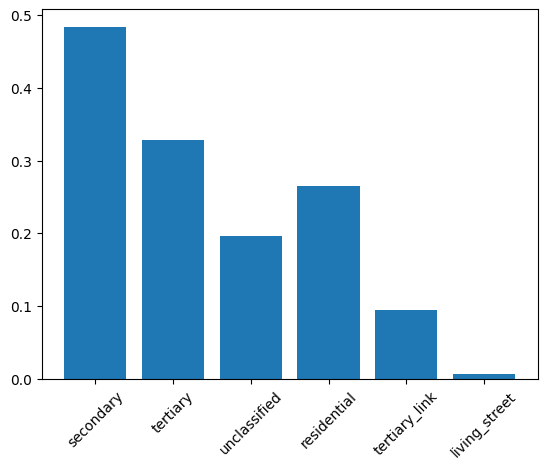

In [516]:
# mean by highway type 

fig, ax = plt.subplots(1, 1)
xticks = d['highway'].unique()
values = [d.loc[d['highway']==h, 'mean'].mean() for h in xticks]

plt.bar(xticks, values)
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'secondary'),
  Text(1, 0, 'tertiary'),
  Text(2, 0, 'unclassified'),
  Text(3, 0, 'residential'),
  Text(4, 0, 'tertiary_link'),
  Text(5, 0, 'living_street')])

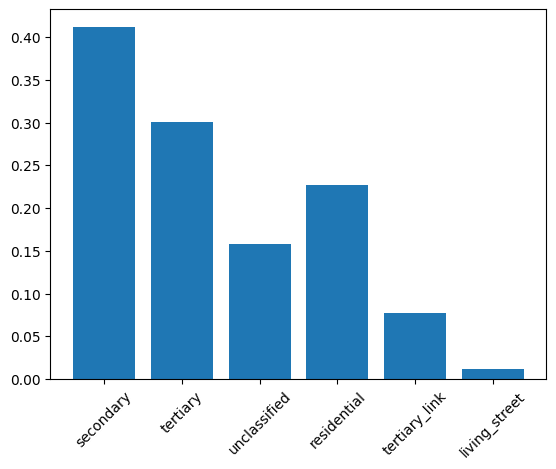

In [517]:
# weighted mean by highway type

fig, ax = plt.subplots(1, 1)
xticks = d['highway'].unique()
values = [d.loc[d['highway']==h, 'weighted_mean'].mean() for h in xticks]

plt.bar(xticks, values)
plt.xticks(rotation=45)

## Priority street network